## Ethogram

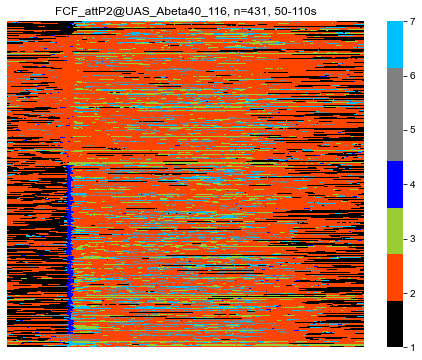

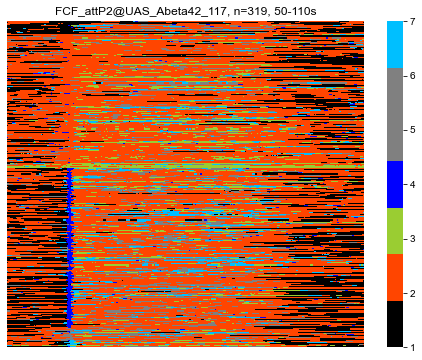

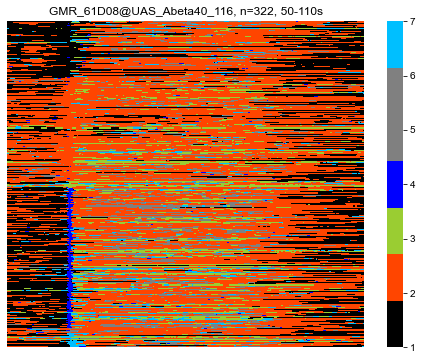

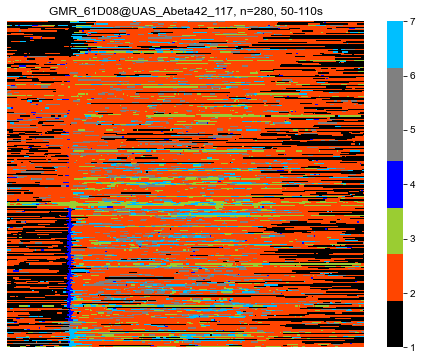

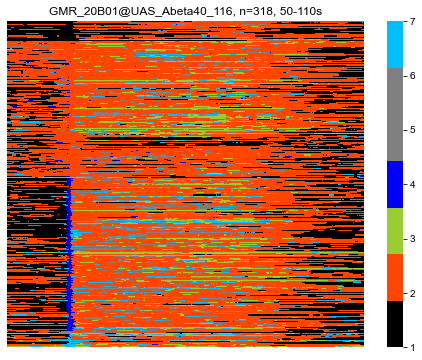

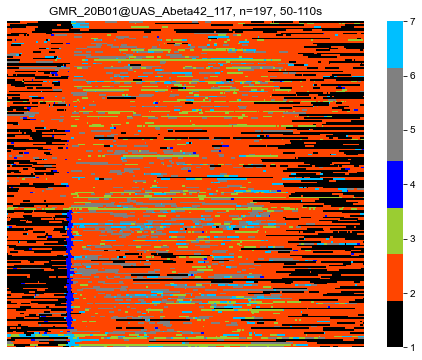

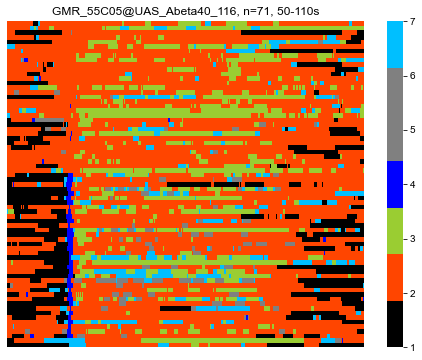

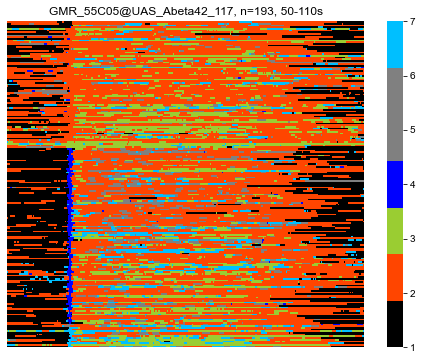

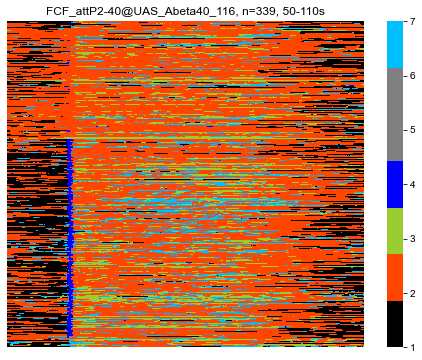

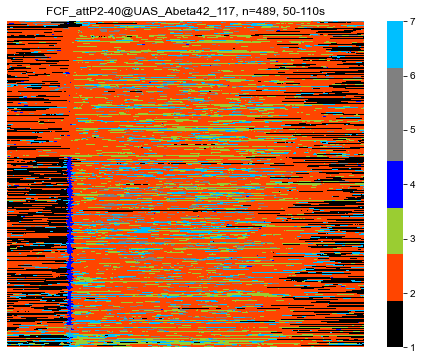

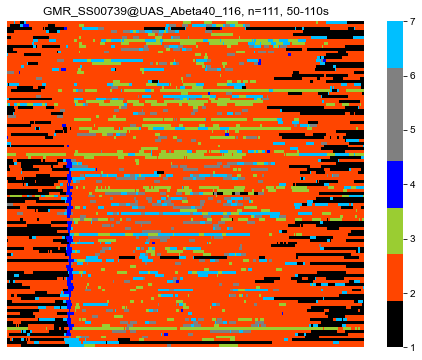

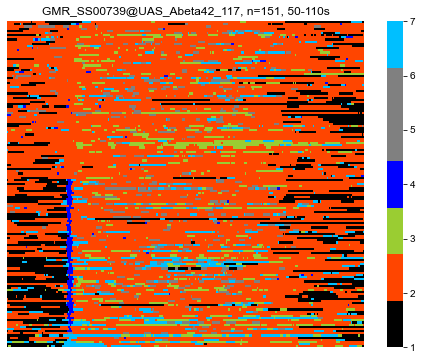

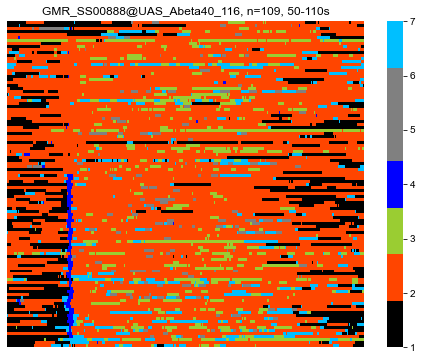

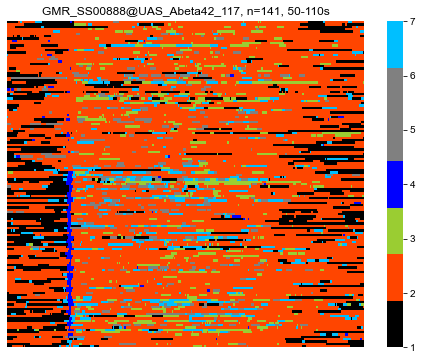

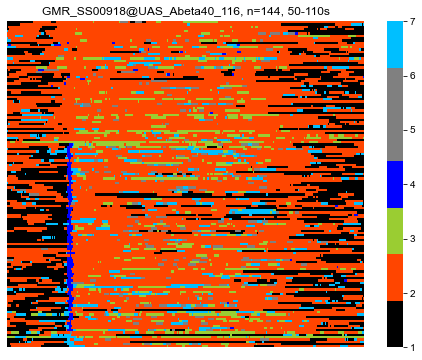

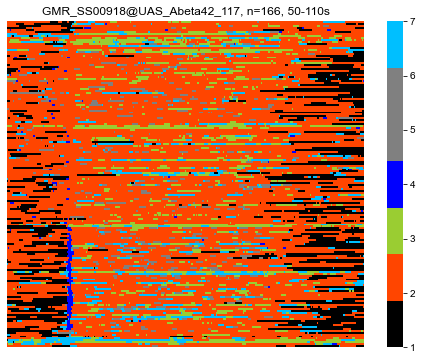

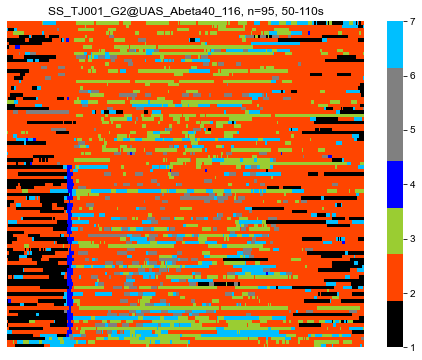

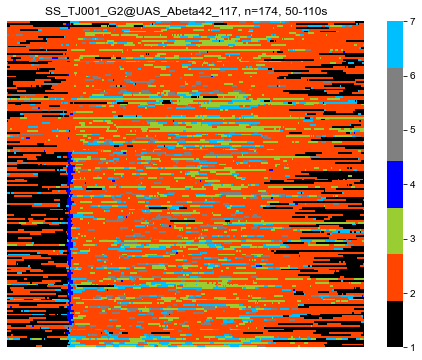

In [ ]:
import behavior
genotypes = [
    'FCF_attP2@UAS_Abeta40_116',
    'FCF_attP2@UAS_Abeta42_117',
    'GMR_61D08@UAS_Abeta40_116',
    'GMR_61D08@UAS_Abeta42_117',
    'GMR_20B01@UAS_Abeta40_116',
    'GMR_20B01@UAS_Abeta42_117',
    'GMR_55C05@UAS_Abeta40_116',
    'GMR_55C05@UAS_Abeta42_117',
    'FCF_attP2-40@UAS_Abeta40_116',
    'FCF_attP2-40@UAS_Abeta42_117',
    'GMR_SS00739@UAS_Abeta40_116',
    'GMR_SS00739@UAS_Abeta42_117',
    'GMR_SS00888@UAS_Abeta40_116',
    'GMR_SS00888@UAS_Abeta42_117',
    'GMR_SS00918@UAS_Abeta40_116',
    'GMR_SS00918@UAS_Abeta42_117',
    'SS_TJ001_G2@UAS_Abeta40_116',
    'SS_TJ001_G2@UAS_Abeta42_117',
]
input = '/Volumes/TOSHIBA/t2'
root = 'dataFiles'
output = '/Volumes/TOSHIBA/t2_behavior_data_analysis'
protocol = 'p_4_60s1x30s0s#p_4_120s10x2s8s#n#n'

behavior.ethogram(input,root,genotypes,protocol,output)

## Visualize probability line plots and bar plots

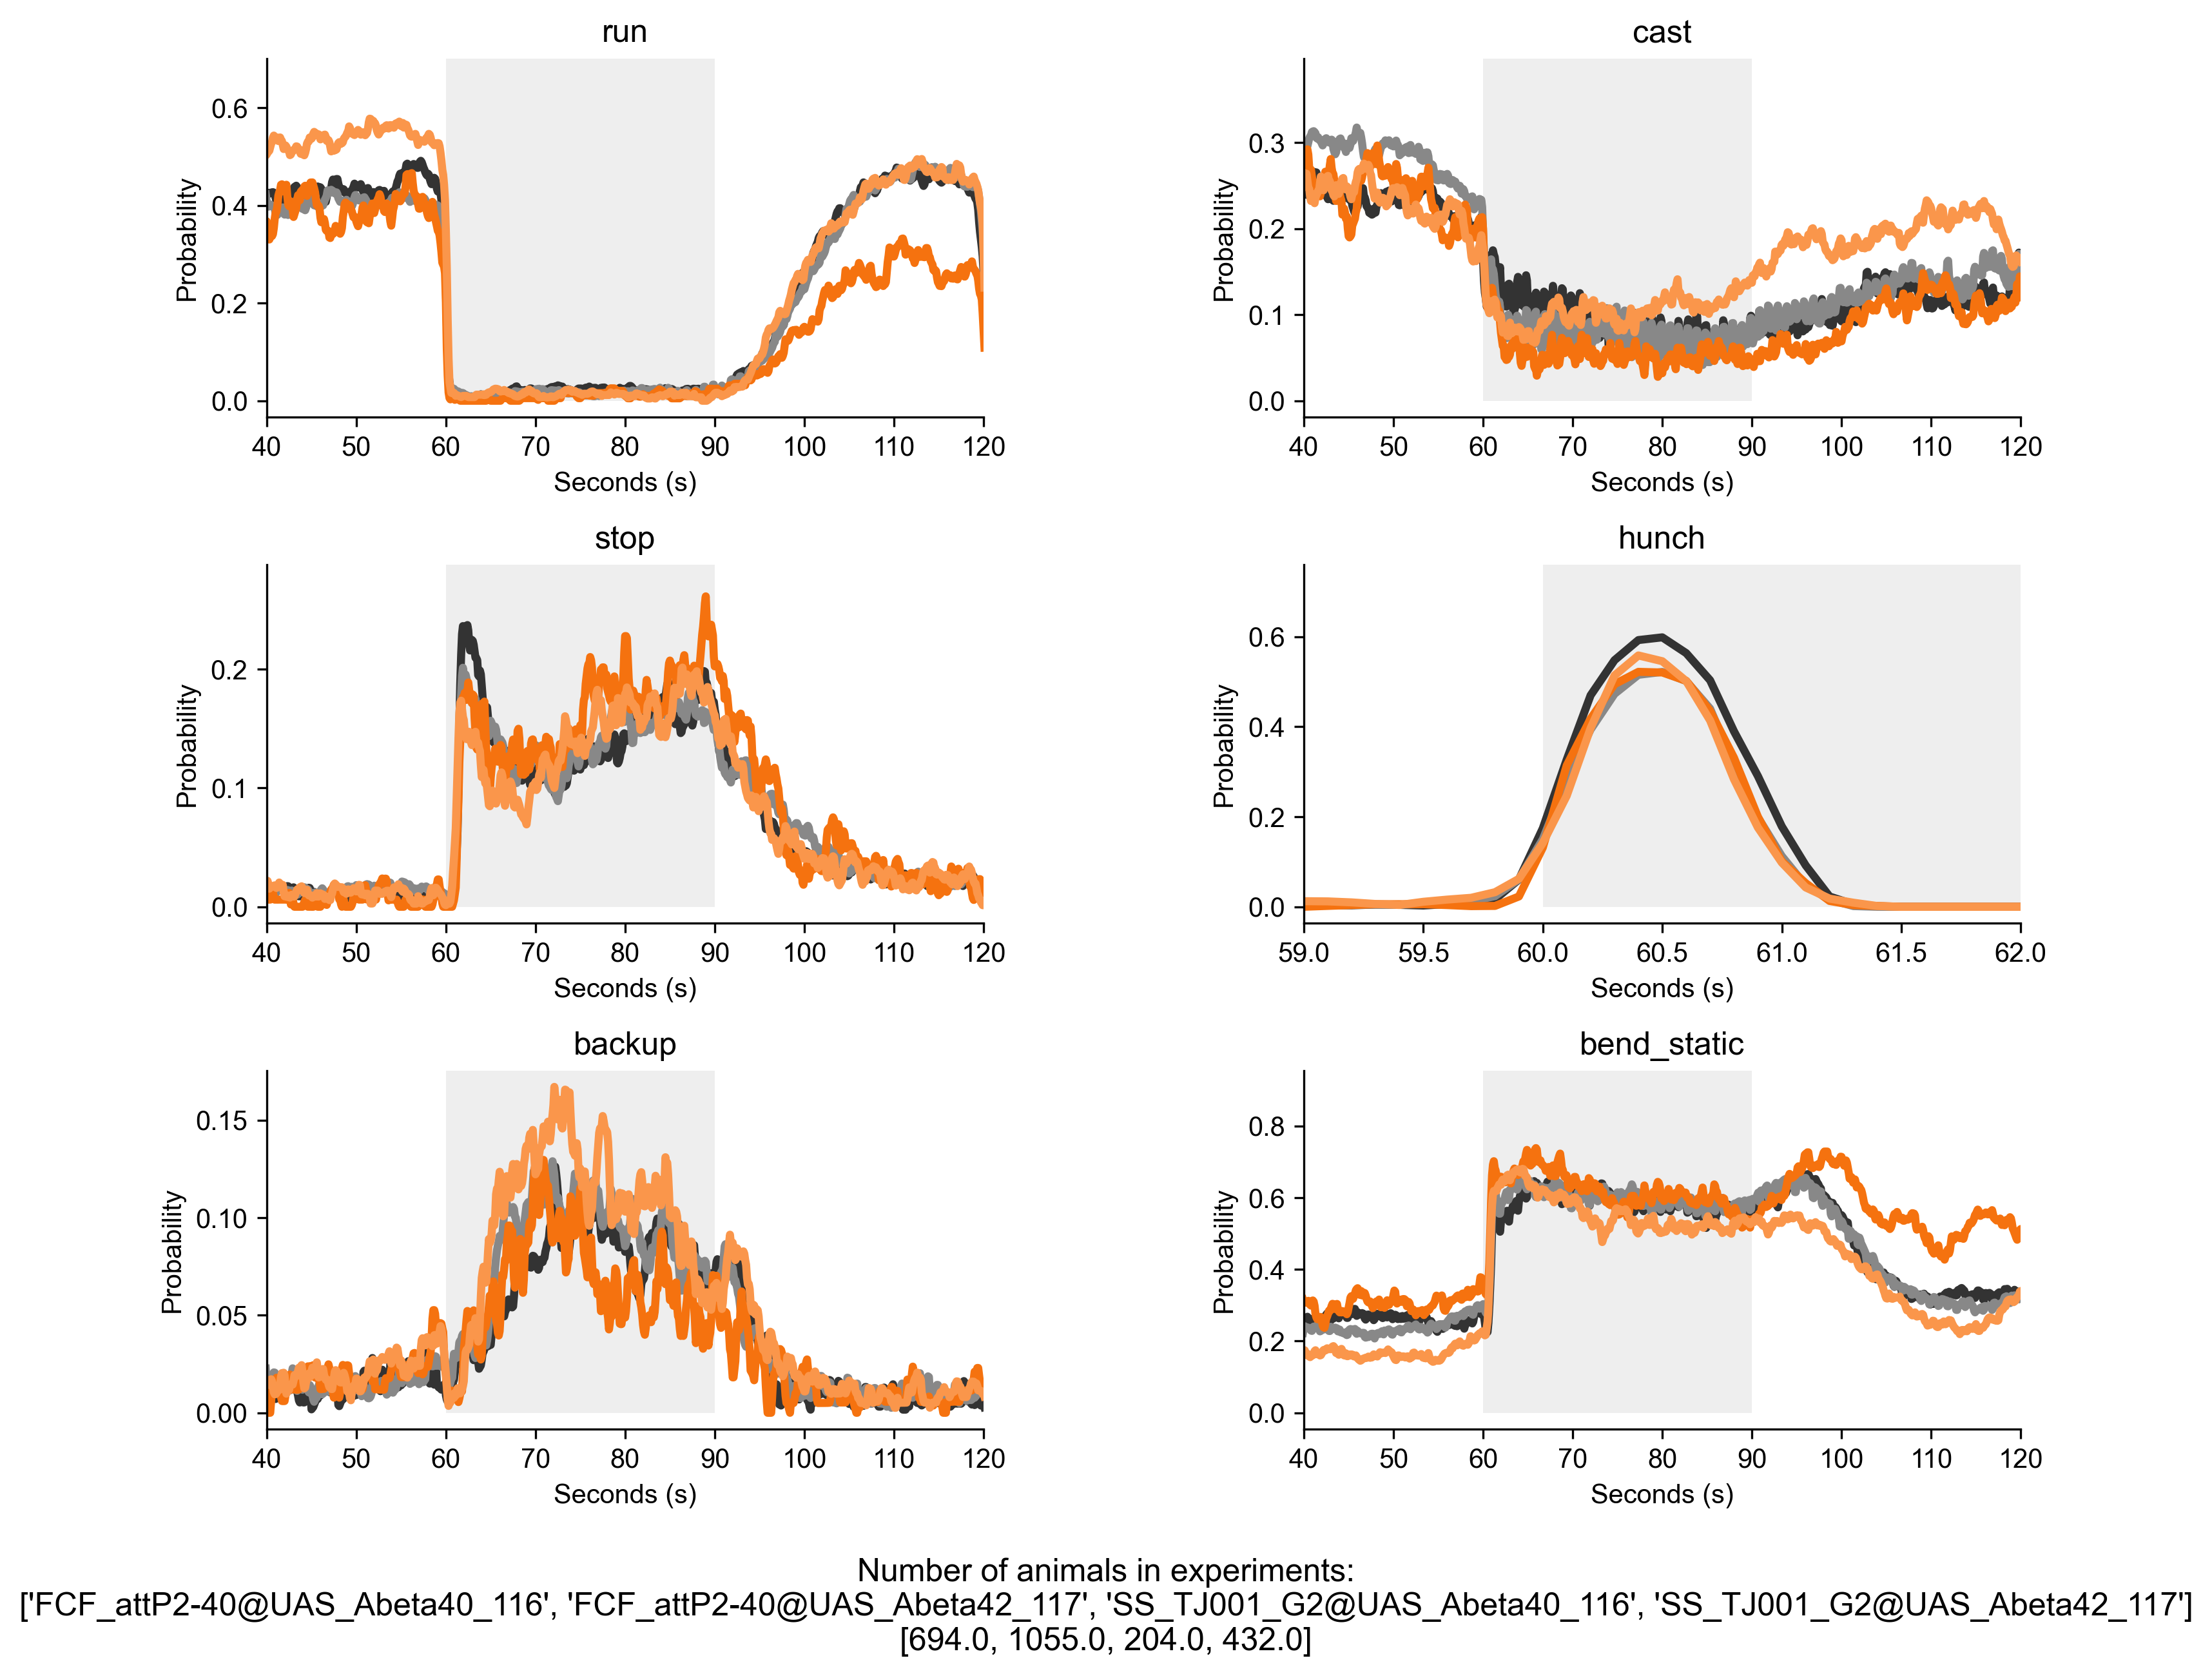

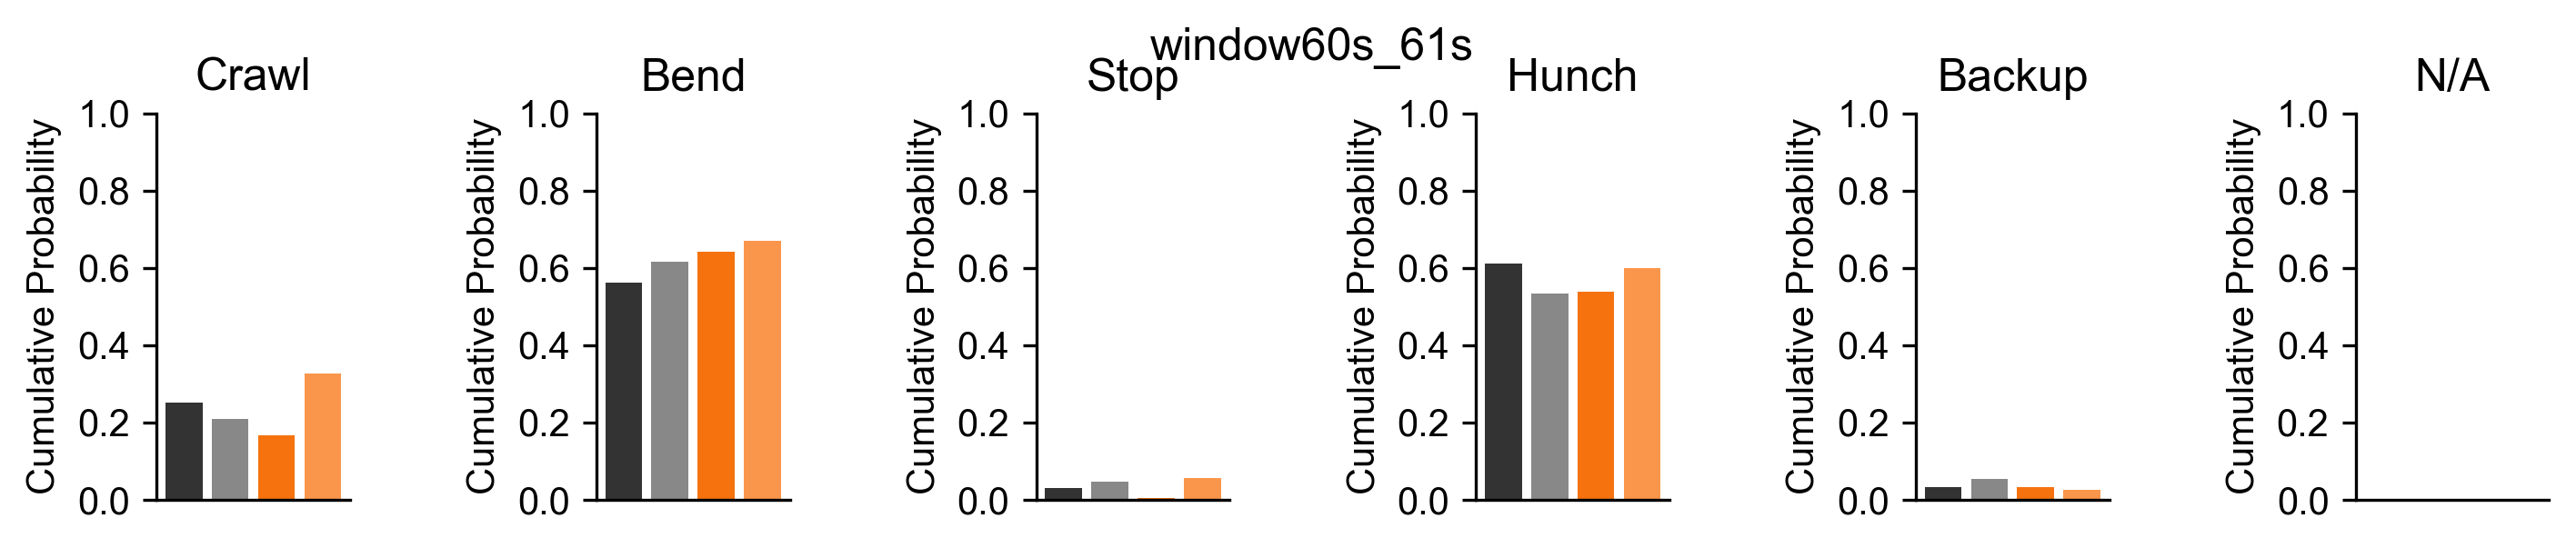

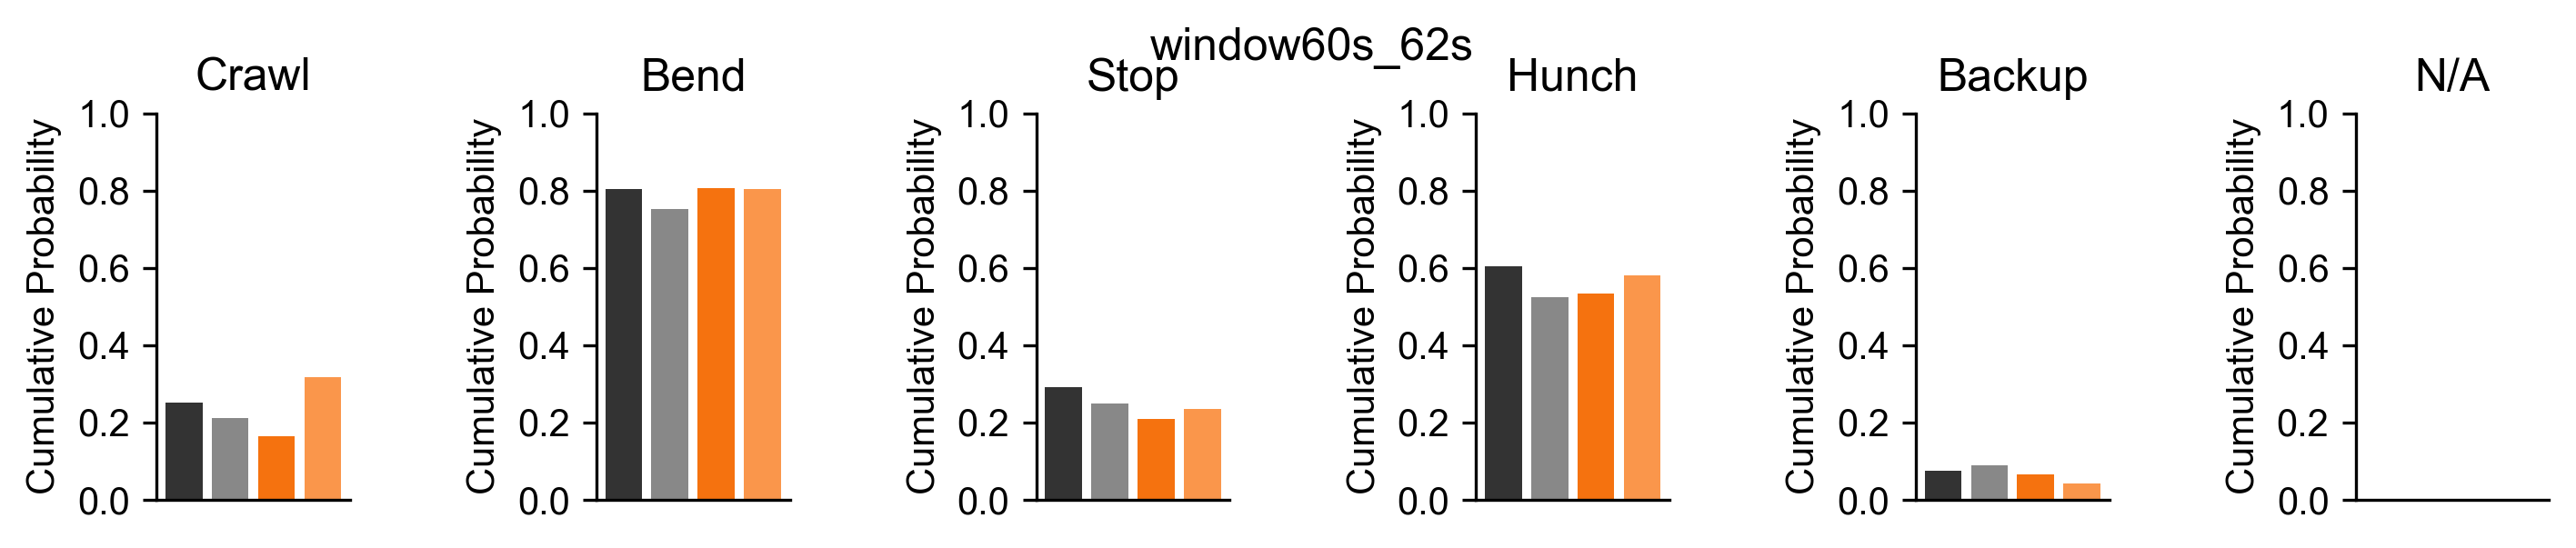

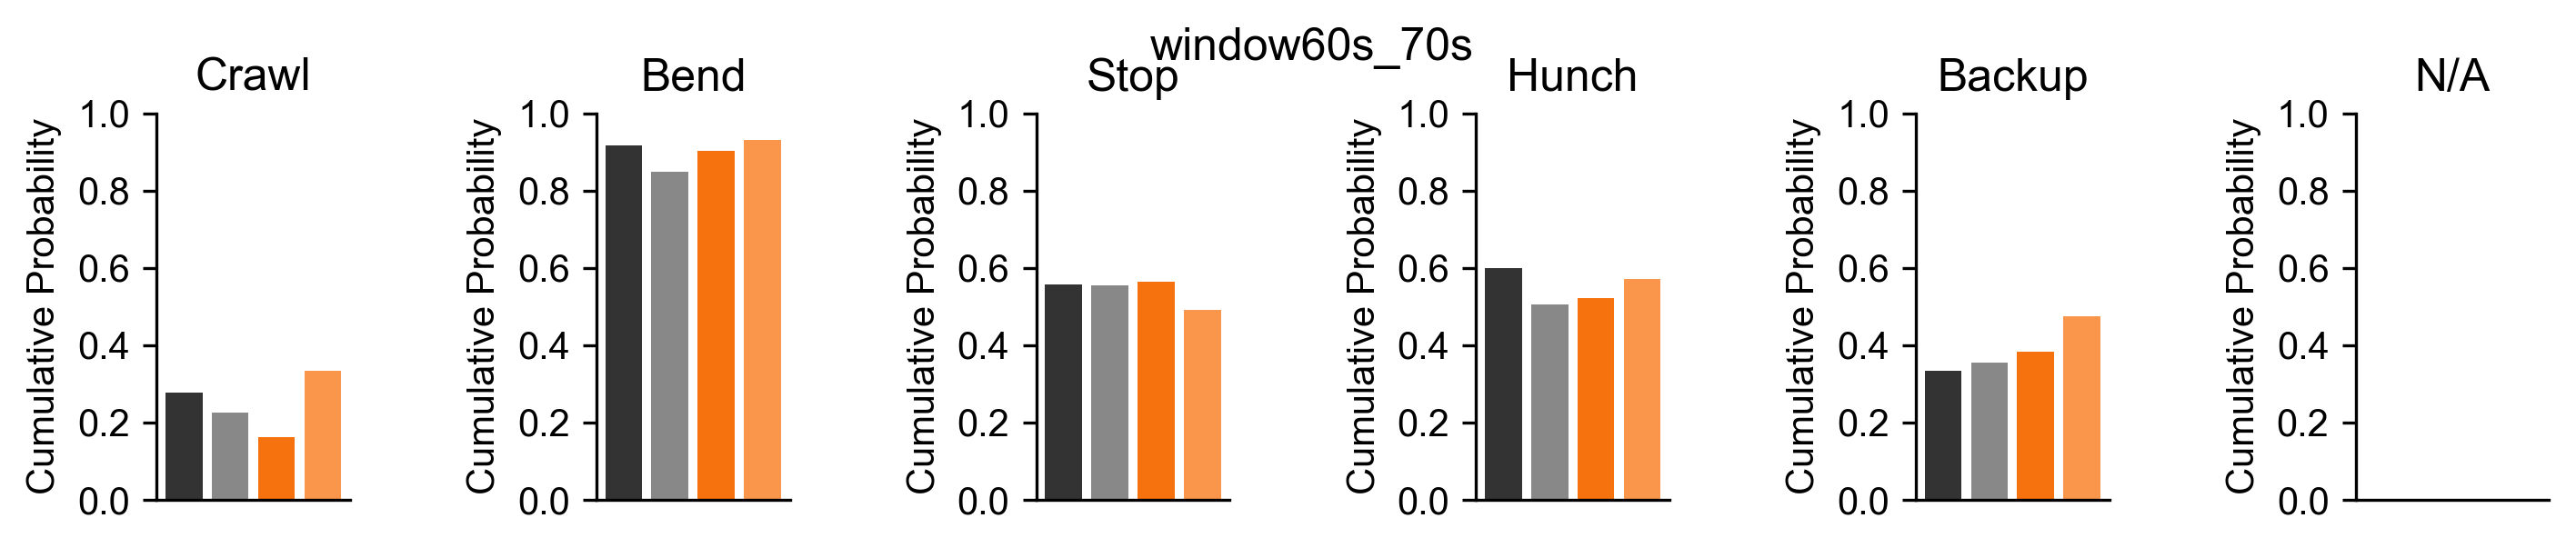

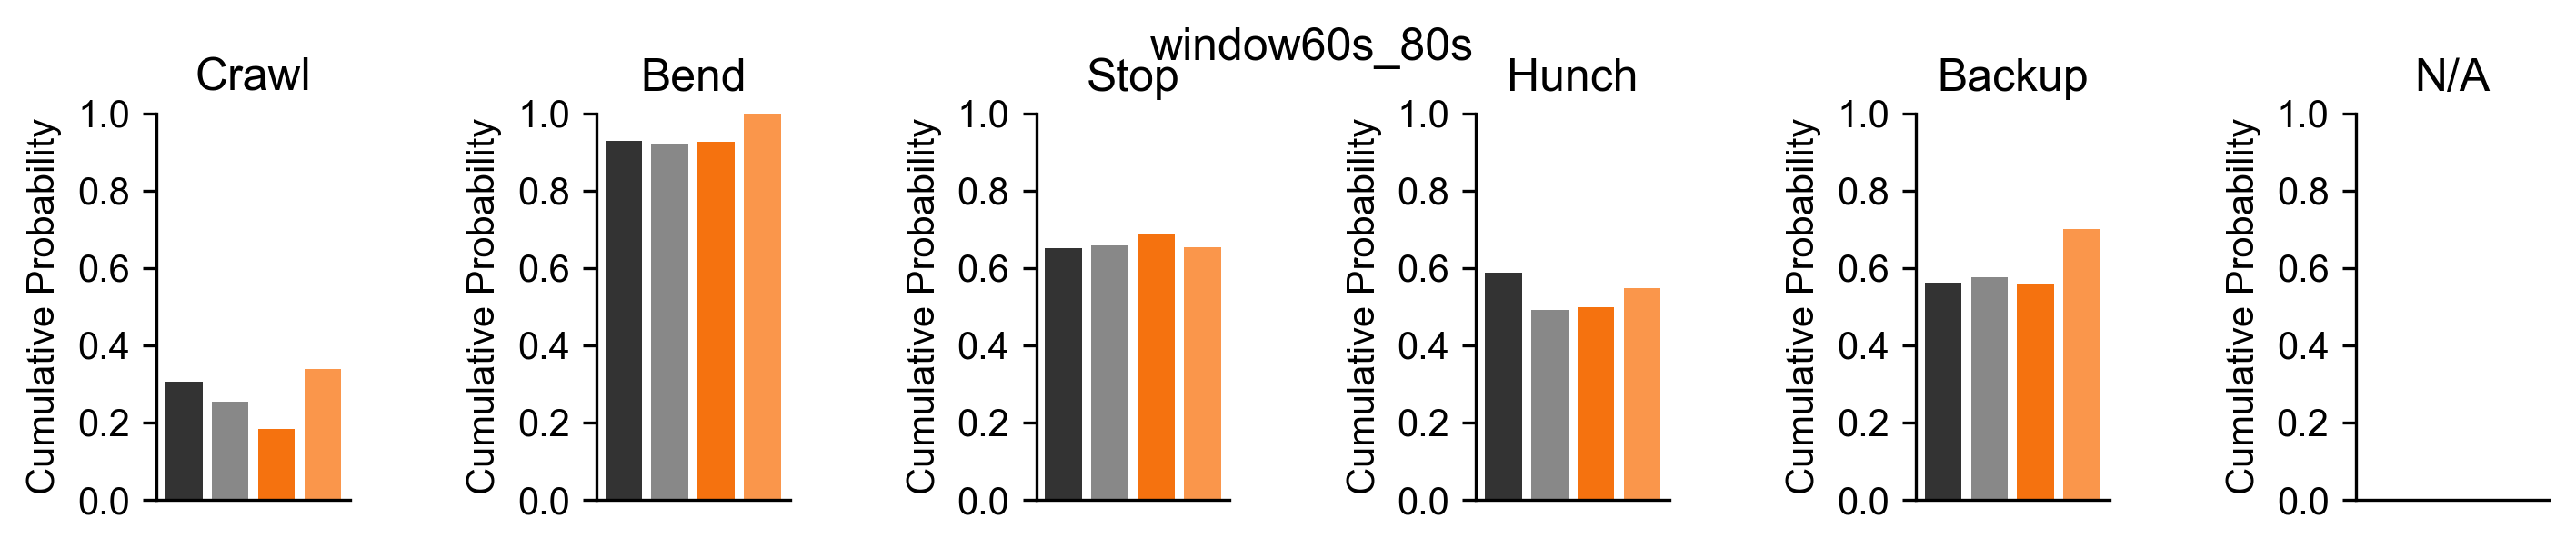

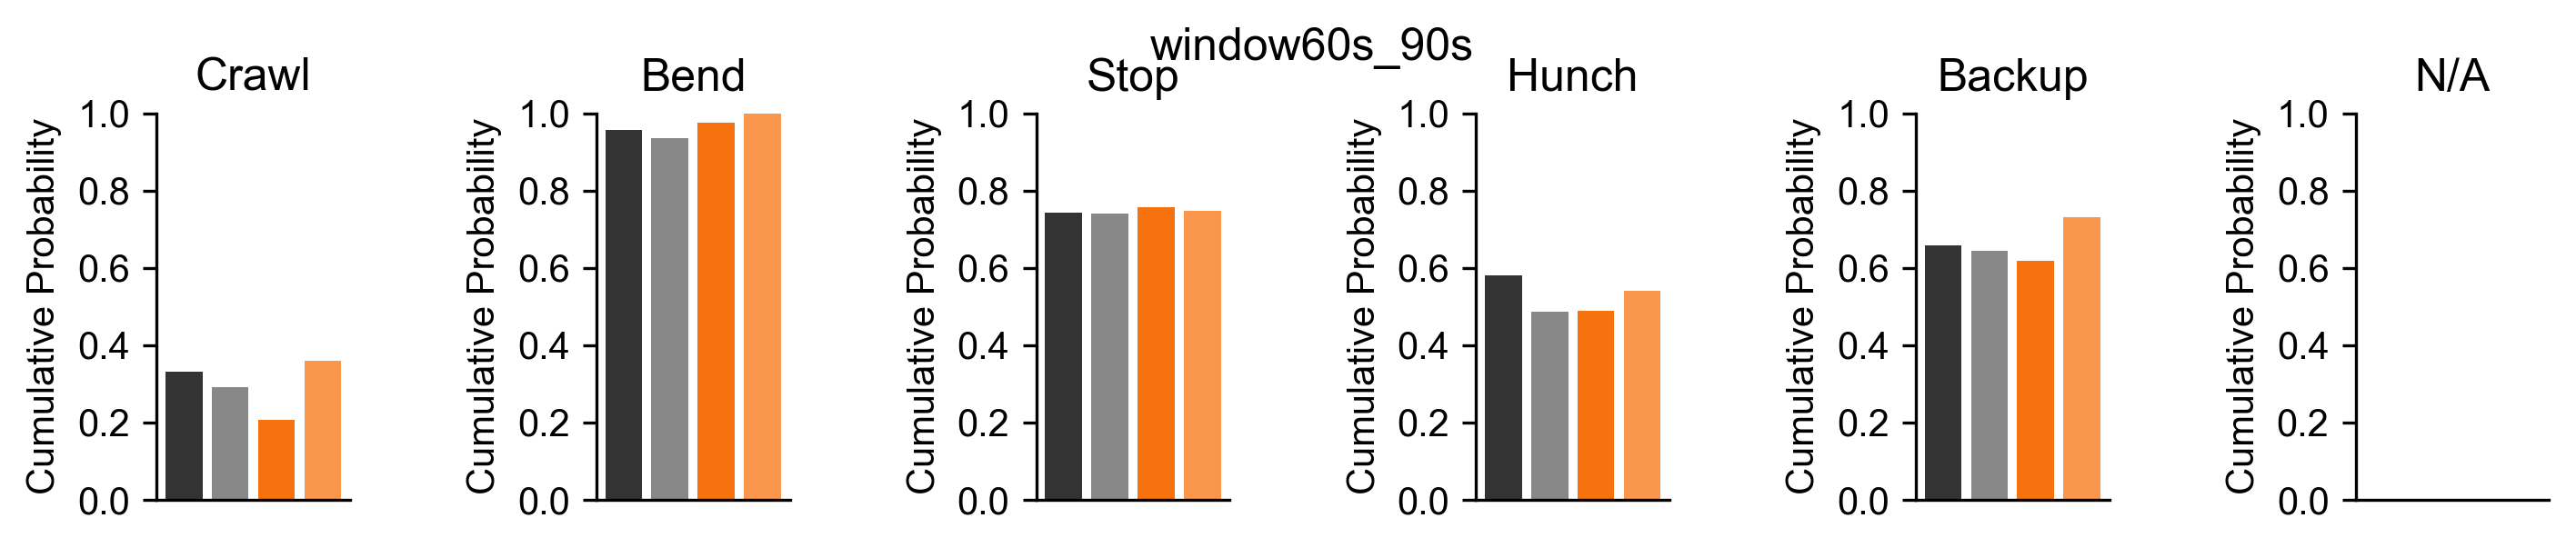

In [3]:
import behavior

# instantiate a list of genotypes to open trx_concatenated and features to extract
# depending on how many genotypes we are visualizing at the same time, the formating of the plot will need to be adjusted
genotypes = [
    'FCF_attP2-40@UAS_Abeta40_116',
    'FCF_attP2-40@UAS_Abeta42_117',
    'SS_TJ001_G2@UAS_Abeta40_116',
    'SS_TJ001_G2@UAS_Abeta42_117',
]

# listed color dictionaru here, for example

#colors = ['#333333','#888888','#1e8f33','#4ecc65'] # Cho green
#colors = ['#333333','#888888','#0385ff','#59afff'] # B1 blue
#colors = ['#333333','#888888','#1100ff','#3661ff'] #B2 blue
#colors = ['#333333','#888888','#f2027a','#f754a6'] # Hb pink
colors = ['#333333','#888888','#f5720f','#fa964b'] # LNa orange

# where to find the files
input = '/Volumes/TOSHIBA/t2'
root = 'dataFiles' 

# where to save
output = '/Volumes/TOSHIBA/t2_behavior_data_analysis'
protocol = 'p_4_60s1x30s0s#p_4_120s10x2s8s#n#n'
neuron = genotypes[2].split('@')[0]

behavior.visualize(input,protocol,root,genotypes,output,neuron,colors,False)


## Visualize cumulative probabilities in a horizontal bar plot

In [ ]:
import os

output_bar_plots = '/Volumes/TOSHIBA/RAL_project'
input = '/Volumes/eq-NCB/t2' # mount to server to retrieve data
# find all RAL lines in the t2 folder
lst = os.listdir(input)
genotypes_exp = sorted([x for x in lst if x.startswith('R61D08_Abeta42')])
genotypes_cont = sorted([x for x in lst if x.startswith('RAL')])
protocol = 'p_5_60s1x30s0s#p_5_120s10x2s8s#n#n'
labels = [genotype.split('@')[1] for genotype in genotypes_exp]
# remove the double control
labels.remove('R61D08_Abeta42')
genotypes_exp.remove('R61D08_Abeta42@R61D08_Abeta42')
# reformat the control genotypes
genotypes_cont = ['{}@{}'.format(label,label) for label in labels]

# just double check that all the genotypes are correct
print(genotypes_cont)
print(genotypes_exp)

In [ ]:
# small function to comute false discovery rate
def fdr(p_vals):

    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals).ravel()
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

In [ ]:
import glob
import scipy.io
import numpy as np
import os
from itertools import combinations
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"

actions = [
    'run',
    'cast',
    'stop',
    'hunch',
    'backup',
    'bend_static'
]

windows = [
    #'window15s_55s',
    'window60s_61s',
    'window60s_62s',
    'window60s_70s',
    #'window60s_80s',
    #'window60s_90s',
]

genotypes_to_plot = []
n_larvae = []

# bar plot visualization & statistical test
for window in windows:
    print('Analzying {} ...'.format(window))

    path = output_bar_plots+'/{}'.format(window)
    if not os.path.exists(path):
        os.makedirs(path)
    
    # for each window, loop through genotypes
    genotypes_to_plot = []
    n_larvae = []

    for genotype in genotypes:
        file = "{}/{}/{}/dataFiles/cumulativeProbabilities.mat".format(input,genotype,protocol)
        cumProb = scipy.io.loadmat(file,squeeze_me = True)
        cumProb = cumProb['cumulativeProbabilities']
        actions_to_plot = []

        for a,action in enumerate(actions):
            data = cumProb[window].item()[action].item()['proba'].item()
            #data = cumProb[window].item()[action].item()['proba'].item() - cumProb[window].item()[action].item()['probacontrol'].item()
            actions_to_plot.append(data)
            n = cumProb[window].item()[action].item()['numberoflarvae'].item()
        
        actions_to_plot = np.array(actions_to_plot)
        genotypes_to_plot.append(actions_to_plot)
        n_larvae.append(n)

    genotypes_to_plot = np.transpose(np.array(genotypes_to_plot))

    ## chi-square test
    # create list, 1 is the index of the reference, then compare all other genotypes pairwise to the reference
    combos = [[1,number] for number in range(len(genotypes))]
    

    for a, action in enumerate(actions):
        pvalues = []
        result = []
        resultFinal = []

        for i,__ in enumerate(combos):
            group1 = genotypes[combos[i][0]]
            group2 = genotypes[combos[i][1]]

            observation = np.array([
                [genotypes_to_plot[a][combos[i][0]]*n_larvae[combos[i][0]],genotypes_to_plot[a][combos[i][1]]*n_larvae[combos[i][1]]],
                [n_larvae[combos[i][0]],n_larvae[combos[i][1]]]
            ])
            test = stats.chi2_contingency(observation)

            statistic = test[0]
            pvalue = test[1]
            pvalues.append(pvalue) # for computing fdr
            padj = pvalue*len(combos) # simple bonferroni's correction
            result.append([group1,group2,statistic,pvalue,padj])
        
        fdrs = fdr(np.array(pvalues))
        fdrs = fdrs.reshape((len(combos),1))
        result = np.array(result)
        resultFinal = np.concatenate((result,fdrs),axis=1)

        resultFinal = pd.DataFrame(resultFinal,columns = ['group1','group2','statistic','pvalue','bonferroni','fdr'])
        resultFinal.to_csv('{}/{}_chisquareTest.csv'.format(path,action))
        print('Writing Chi-square statistical test results...')
            
    

    for i,action in enumerate(actions):
        fig,ax = plt.subplots(1,1, figsize=(4,7), dpi=300)

        df = {'prob':genotypes_to_plot[i],'n':n_larvae,'name':labels}
        df = pd.DataFrame(data=df, index=labels)
        df = df.sort_values(by=['prob'])
        df.to_csv('{}/{}_dataframe.csv'.format(path,action))

        gwas = pd.DataFrame(data = genotypes_to_plot[i],index=labels)
        gwas.to_csv('{}/{}_dataframe_forGWAS.csv'.format(path,action))

        captions = ['{} (n = {})'.format(str(df['name'][i]),str(df['n'][i])) for i in range(len(genotypes))]
        
        ax.barh(np.arange(len(genotypes)),df['prob'],color='gray')
        ax.set_title(action)
        ax.set_xlabel('Cumulative Probability')
        ax.set_yticks(np.arange(len(genotypes)),labels=captions)
        ax.invert_yaxis()
    
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

        plt.tight_layout()
        plt.savefig('{}/{}.svg'.format(path,action), format='svg',bbox_inches="tight")
        plt.savefig('{}/{}.eps'.format(path,action), format='eps',bbox_inches='tight')